In [160]:
%load_ext autoreload
%autoreload 2

import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as T
from matplotlib import pyplot as plt #for visualizing 

# #Trainer Imports
# from skimage.metrics import peak_signal_noise_ratio as psnr
# from skimage.metrics import structural_similarity as ssim

#From the local python files
from datasets_denoising import DenoisingPairedDataset
from trainer_denoising import DenoisingTrainer
from trainer_denoising import perceptual_loss, combined_loss, DenoisingTrainer
from models_denoising import DenoisingCNN, DenoisingUNet, ImprovedDenoisingUNet, ResidualUNet, MotionAwareDenoiser

from losses import SSIMLoss, CombinedLoss



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Root directories

In [161]:
root_dir = 'aquarium_pretrain'

splits = ['train', 'test','valid']

model_path = '/home/ubuntu/cs230_VIVEKA/saved_models'

# Main model training pipeline

##### create datasets, dataloaders, model, trainer

In [162]:
hyperparams = ['batch_size', 'lr', 'num_epochs', 'dropout_rate']
batch_size = 32
num_epochs = 30
lr = 1e-3


In [163]:
#Transforms
transform_regular = T.ToTensor()

transform_resize = T.Compose( [ T.Resize((224,224)) , T.ToTensor() ] ) #IMPORTANT: size is taken from datasets.py transform in order to match 

create dataset

In [164]:
#Dataset creation with default x_path and y_path.
train_data = DenoisingPairedDataset(root_dir=root_dir, split='train', transform=transform_resize) 
valid_data = DenoisingPairedDataset(root_dir=root_dir, split='valid', transform=transform_resize)
test_data = DenoisingPairedDataset(root_dir=root_dir, split='test', transform=transform_resize)

create DataLoaders

In [165]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

create Model, device

In [166]:
#define models
model_simple = DenoisingCNN()
model_unet = DenoisingUNet()
model_unet_improved = ImprovedDenoisingUNet()
model_residual_unet = ResidualUNet()
model_motionaware = MotionAwareDenoiser()

In [167]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [168]:
model = model_residual_unet #Edit model here

model.to(device)
#criterion = nn.MSELoss()
criterion = CombinedLoss(device=device)

optimizer = torch.optim.Adam(model.parameters(), lr = lr)


In [169]:
#Save model and loss specifications
modelName = str(model).split('(')[0]
modelLoss = str(criterion).split('(')[0]

save_filename = 'model_weights.pth'
save_folder = modelName + '_' + modelLoss

os.makedirs( os.path.join('saved_models',save_folder) , exist_ok=True)

save_path = os.path.join('saved_models', save_folder, save_filename)

print(f"Model {modelName} with loss {modelLoss} will be saved to: {save_path}")

Model ResidualUNet with loss CombinedLoss will be saved to: saved_models/ResidualUNet_CombinedLoss/model_weights.pth


In [159]:
trainer = DenoisingTrainer(model, device, criterion, optimizer, save_path=save_path)

##### Train model

Epoch 1/10, Training Loss: 0.4807
Epoch 1/10, Validation Loss: 0.3011
Model saved with validation loss: 0.3011
Epoch 2/10, Training Loss: 0.2460
Epoch 2/10, Validation Loss: 0.2084
Model saved with validation loss: 0.2084
Epoch 3/10, Training Loss: 0.1942
Epoch 3/10, Validation Loss: 0.1778
Model saved with validation loss: 0.1778
Epoch 4/10, Training Loss: 0.1701
Epoch 4/10, Validation Loss: 0.1603
Model saved with validation loss: 0.1603
Epoch 5/10, Training Loss: 0.1527
Epoch 5/10, Validation Loss: 0.1392
Model saved with validation loss: 0.1392
Epoch 6/10, Training Loss: 0.1380
Epoch 6/10, Validation Loss: 0.1263
Model saved with validation loss: 0.1263
Epoch 7/10, Training Loss: 0.1266
Epoch 7/10, Validation Loss: 0.1142
Model saved with validation loss: 0.1142
Epoch 8/10, Training Loss: 0.1164
Epoch 8/10, Validation Loss: 0.1124
Model saved with validation loss: 0.1124
Epoch 9/10, Training Loss: 0.1125
Epoch 9/10, Validation Loss: 0.1054
Model saved with validation loss: 0.1054
E

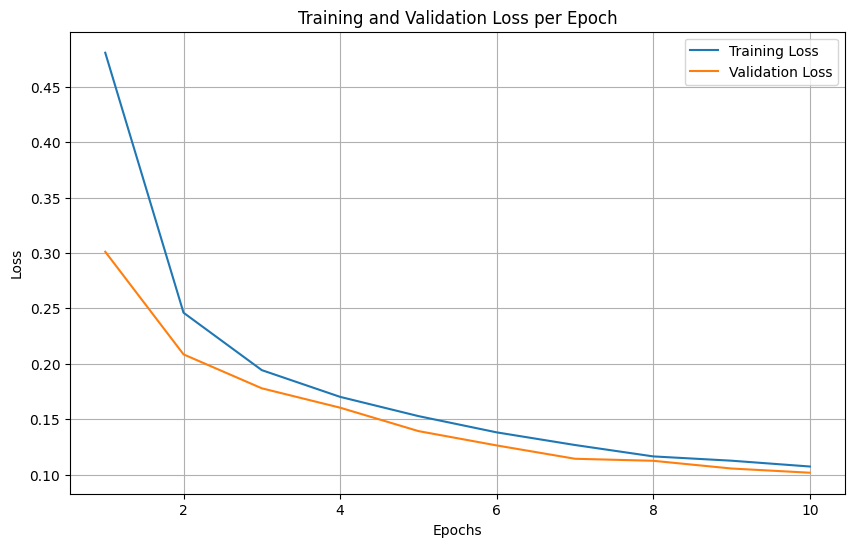

In [147]:
trainer.train(train_loader, valid_loader, num_epochs=10)

##### Evaluate model

In [148]:
val_loss, val_psnr, val_ssim = trainer.evaluate(valid_loader)
#print(f"Validation - Loss: {val_loss:.4f}, PSNR: {val_psnr:.4f}, SSIM: {val_ssim:.4f}")

test_loss, test_psnr, test_ssim = trainer.evaluate(test_loader)
#print(f"Test - Loss: {test_loss:.4f}, PSNR: {test_psnr:.4f}, SSIM: {test_ssim:.4f}")


Avg Loss: 0.1016, Avg PSNR: 23.1575, Avg SSIM: 0.7977
Avg Loss: 0.1087, Avg PSNR: 23.1241, Avg SSIM: 0.8088


# visualize dataset, model outputs

##### visualize X,Y pairs

In [149]:
def unnormalize(img_tensor, mean, std):
    """
    Unnormalize a tensor image given the original mean and standard deviation.
    """
    img_tensor = img_tensor.clone().detach().cpu()
    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)
    return img_tensor

##### Visualize Y_Pred, Y pairs

In [150]:
def visualize_output(model, data, device, idx, normalize=True, normalization_mean=[0.5, 0.5, 0.5], normalization_std=[0.5,0.5,0.5]):
    ''' Plots the input, ground truth, and model output of a given ID in the dataset. 
        ID must be within (0, len(dataset)). 
        Unnormalizes the image if
    '''
    if idx >= len(data): raise IndexError("idx out of bounds of dataset length")

    noisy_image, clean_image = data[idx] 
    noisy_image = noisy_image.unsqueeze(0).to(device)
    filename = data.get_filename(idx)
    
    with torch.no_grad():
        predicted_image = model(noisy_image).cpu().squeeze(0) #create predicted image from model 

    if normalize: #removes normalization on the dataset images if it was applied in a transform; normalization_mean and std are static/fixed as of now and defined earlier in the notebook
        noisy_image = unnormalize(noisy_image.cpu().squeeze(0), normalization_mean, normalization_std)
        clean_image = unnormalize(clean_image, normalization_mean, normalization_std)
    else:
        noisy_image = noisy_image.cpu().squeeze(0) #if no normalization for noisy_image
    
    predicted_image = predicted_image.permute(1, 2, 0).clip(0, 1)  # Transpose for plotting
    
    print(filename)
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Filename: {filename}", fontsize=16)
    plt.subplot(1, 3, 1)
    plt.imshow(noisy_image.permute(1, 2, 0))
    plt.title("Noisy Input")
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_image)
    plt.title("Model Output")
    plt.subplot(1, 3, 3)
    plt.imshow(clean_image.permute(1, 2, 0))
    plt.title("Ground Truth")
    plt.show()

In [172]:
model_path = save_path
model_path = 'saved_models/DenoisingUNet_CombinedLoss/model_weights.pth'
model_vis = DenoisingUNet()
model_vis.load_state_dict(torch.load(model_path))
model_vis.eval()
model_vis.to(device)

/tmp/ipykernel_2611/71106287.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_vis.load_state_dict(torch.load(model_path))


DenoisingUNet(
  (enc_conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (enc_conv1a): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (enc_conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (enc_conv2a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (enc_conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (enc_conv3a): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout3): Dropout(p=0.4, inplace=False)
  (dec_conv1): Sequential(
    

IMG_2320_jpeg_jpg.rf.4ba216e1f004fd1182ca0dfb53ccce19.jpg


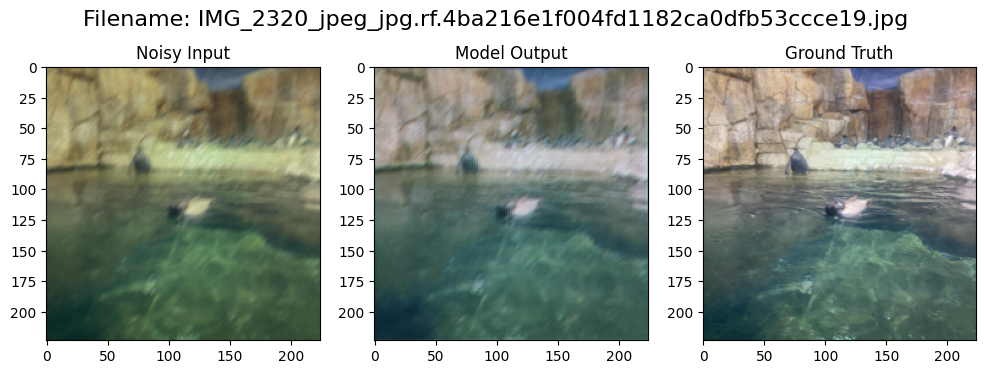

In [177]:
visualize_output(model=model_vis, data=train_data, device=device, idx=440, normalize=False)

In [ ]:
model_path = 'saved_models/best_denoising_model_simple_perceptual.pth'
model_vis = DenoisingCNN()
model_vis.load_state_dict(torch.load(model_path))
model_vis.eval()
model_vis.to(device)

IMG_2313_jpeg_jpg.rf.c493f660b195b8edec3ee3fa0c626868.jpg


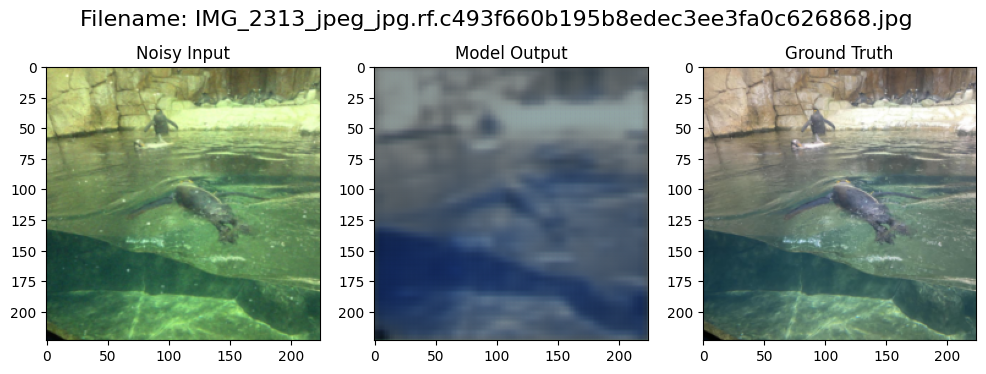

In [55]:
visualize_output(model=model_vis, data=train_data, device=device, idx=350, normalize=False)